# Auto-Encoders

## Credits 

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Maximillian F. Vording ([maximillian91](https://github.com/maximillian91)).
</span>

# Dependencies and supporting functions
Load dependencies and supporting functions by running the code block below.

In [14]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

# Introducing the auto-encoder
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We'll start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We'll experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you're about to learn is very simple compared to recent advances (e.g. [the Ladder network](https://arxiv.org/abs/1507.02672) and [VAEs](https://arxiv.org/abs/1312.6114)). However, the basic idea stays the same.

#### The Auto-encoder architecture

<img src="AE.png" alt="Drawing" style="width: 300px;"/>

AEs are used within unsupervised learning, in which you do not have a target $y$. Instead it *encodes* an input $x$ into a latent state $z$ and decodes $z$ into a reconstruction $\hat{x}$. This way the parameters of the network can be optimized w.r.t. the difference between $x$ and $\hat{x}$. Depending on the input distribution, the difference can be measured in various ways, e.g. mean squared error (MSE). In many applications the auto-encoder will find an internal state of each data point corresponding to a feature. So if we are to model the MNIST dataset, one could expect that the internal state would correspond to a digit-class and/or the shape/style.

**The exercises are found at the bottom of the notebook**

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through $\textit{included_classes}$, to speed up training.

In [15]:
from sklearn.utils import shuffle

# To speed up training we'll only work on a subset of the data containing only the numbers 0, 1.
data = np.load('../mnist.npz')
# Possible classes
classes = list(range(10))
# Set classes used, starting from 0.
included_classes = [0, 1, 4, 9] 
idxs_train = []
idxs_valid = []
idxs_test = []
num_classes = 0
for c in included_classes:
    if c in classes:
        num_classes += 1
        idxs_train += np.where(data['y_train'] == c)[0].tolist()
        idxs_valid += np.where(data['y_valid'] == c)[0].tolist()
        idxs_test += np.where(data['y_test'] == c)[0].tolist()

print("Number of classes included:", num_classes)
x_train = data['X_train'][idxs_train].astype('float32')
# Since this is unsupervised, the targets are only used for validation.
targets_train = data['y_train'][idxs_train].astype('int32')
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)


x_valid = data['X_valid'][idxs_valid].astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = data['X_test'][idxs_test].astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

Number of classes included: 4
training set dim(20457, 784).
validation set dim(3999, 784).
test set dim(4106, 784).


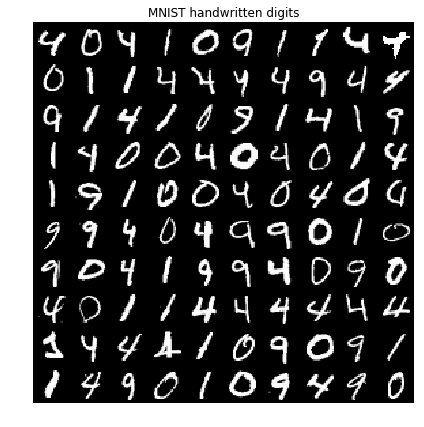

In [11]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using relu units as non-linearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid non-linearity to model the reconstruction.

In [12]:
from tensorflow import layers
from tensorflow.contrib.layers import fully_connected 
from tensorflow.python.ops.nn import relu, sigmoid

In [13]:
# define in/output size
num_features = x_train.shape[1]

# reset graph
reset_default_graph()

# define the model
# Input placeholder
x_pl = tf.placeholder(tf.float32, [None, num_features], 'x_pl')

# Encoder
l_enc = layers.dense(inputs=x_pl, units=128, activation=relu, name='l_enc')

# The latent variable layer, where we can try out activation functions
l_z = layers.dense(inputs=l_enc, units=2, activation=None, name='l_z') # None indicates a linear output.

# Decoder
l_dec = layers.dense(inputs=l_z, units=128, activation=relu, name='l_dec')

# Output layer, sigmoid due to bounded pixel values in range [0,1]
l_out = layers.dense(inputs=l_dec, units=num_features, activation=sigmoid) # iid pixel intensities between 0 and 1.

Following we define the TensorFlow functions for training and evaluation.

In [7]:
# Calculate loss - TRY another error function
# loss_per_pixel = tf.square(tf.subtract(l_out, x_pl))
loss_per_pixel = - x_pl * tf.log(l_out) - (1 - x_pl) * tf.log(1 - l_out)
loss = tf.reduce_mean(loss_per_pixel, name="mean_error")

# If you want regularization
reg_scale = 0.0005
regularize = tf.contrib.layers.l2_regularizer(reg_scale)
params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
reg_term = tf.reduce_sum([regularize(param) for param in params])
loss += reg_term

# define our optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Training operator for applying the loss gradients in backpropagation update
train_op = optimizer.minimize(loss)

In [8]:
# test the forward pass
_x_test = np.zeros(shape=(32, num_features))
# initialize the Session
sess = tf.Session()
# test the forward pass
sess.run(tf.global_variables_initializer())
feed_dict = {x_pl: _x_test}
res_forward_pass = sess.run(fetches=[l_out], feed_dict=feed_dict)
print("l_out", res_forward_pass[0].shape)

l_out (32, 784)


In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

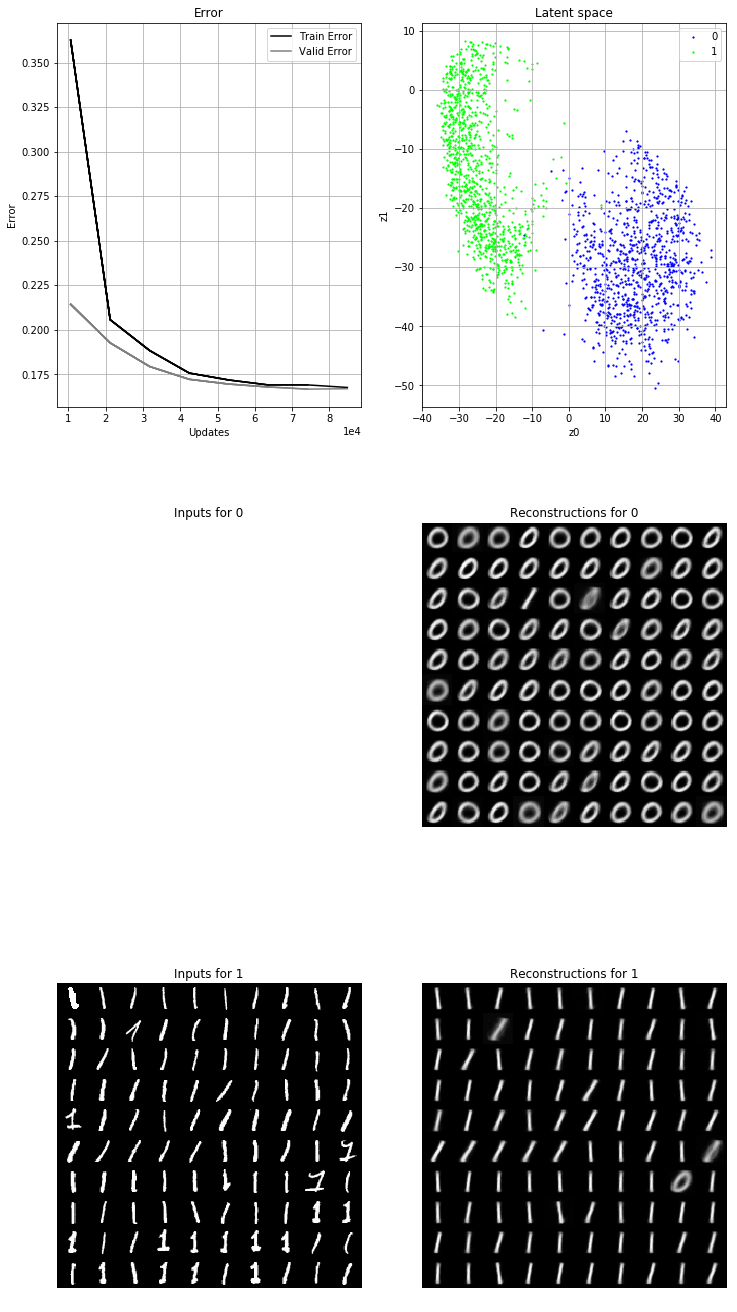

In [9]:
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
plt.figure(figsize=(12, 24))

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)    
            x_batch = x_train[idxs]
            # setup what to fetch, notice l
            fetches_train = [train_op, loss, l_out, l_z]
            feed_dict_train = {x_pl: x_batch}
            # do the complete backprob pass
            res_train = sess.run(fetches_train, feed_dict_train)
            _, batch_loss, train_out, train_z = tuple(res_train)
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)]

        # evaluate
        fetches_eval = [loss, l_out, l_z]
        feed_dict_eval = {x_pl: x_valid}
        res_valid = sess.run(fetches_eval, feed_dict_eval)
        eval_loss, eval_out, eval_z = tuple(res_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(num_classes+1,2,1)
        plt.title('Error')
        plt.legend(['Train Error', 'Valid Error'])
        plt.xlabel('Updates'), plt.ylabel('Error')
        plt.plot(updates, train_loss, color="black")
        plt.plot(updates, valid_loss, color="grey")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(num_classes+1,2,2)
        plt.cla()
        plt.title('Latent space')
        plt.xlabel('z0'), plt.ylabel('z1')
        color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
        legend_handles = []
        for i, c in enumerate(included_classes):
            clr = next(color)
            h = plt.scatter(eval_z[targets_valid==c, 0], eval_z[targets_valid==c, 1], c=clr, s=5., lw=0, marker='o', )
            legend_handles.append(h)
        plt.grid('on')
        plt.legend(legend_handles, included_classes)
        
        c=0
        for k in range(3, 3 + num_classes*2, 2):
            plt.subplot(num_classes+1,2,k)
            plt.cla()
            plt.title('Inputs for %i' % included_classes[c])
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==included_classes[c]][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            plt.subplot(num_classes+1,2,k+1)
            plt.cla()
            plt.title('Reconstructions for %i' % included_classes[c])
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = eval_out[targets_valid==included_classes[c]][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            c+=1
      
        
        plt.savefig("out52.png")
        display(Image(filename="out52.png"))
        clear_output(wait=True)
        
except KeyboardInterrupt:
    pass
    

### Optional Exercises - Analyzing the AE
1. The above implementation of an AE is very simple.
    - Experiment with the number of layers and non-linearities in order to improve the reconstructions.
    - What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?
    - Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. 
        - Try the combination: *included_classes=[0, 1, 4, 9]*, to see the pros and cons in the auto-encoder representation of digits. 
    - Test different optimization algorithms and decide whether you should use regularizers.
       
2. Currently we optimize w.r.t. mean squared error. 
    - Find another error function that could fit this problem better. HINT: Consider the sigmoid output as probabilities of generating a 0 (black) or 1 (white) pixel value, like 784 imbalanced coin-tossing processes.  
    - Evaluate whether the error function is a better choice and explain your findings.

3. Complexity of the bottleneck.
    - To see if we can increase the models representational power, increase the number of units in the latent layer.
    - Train and then visualize the latent space using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

### Exercise 2 - Adding classification (for the ambitious)
The above training has been performed unsupervised. Now let us assume that we only have a fraction of labeled data points from each class (implemented below). As we know, semi-supervised learning can be utilized by combining unsupervised and supervised learning. Now you must analyze whether a trained AE from the above exercise can aid a classifier.

1. Build a simple classifier (like the ones from week1) where you:
    - *Train on the labeled dataset and evaluate the results.*
2. Build a second classifier and train on the latent output $z$ of the AE.
3. Build a third classifier and train on the reconstructions of the AE.
4. Evaluate the classifiers against each other and implement a model that improves the classification by combining the input, latent output and reconstruction.

labeled training set dim(40, 784).


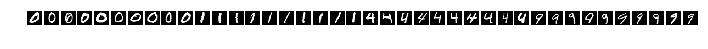

In [24]:
# Generate a subset of labeled data points

num_labeled = 10 # You decide on the size of the fraction...

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

idxs_train_l = []
for i in included_classes:
    idxs = np.where(targets_train == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_train[idxs_train_l]
targets_train_l = targets_train[idxs_train_l]
print("labeled training set dim(%i, %i)." % x_train_l.shape)

plt.figure(figsize=(12, 7))
for i in range(num_classes*num_labeled):
    im = x_train_l[i].reshape((28, 28))
    plt.subplot(1, num_classes*num_labeled, i + 1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')